In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utilities import thresholds
from utilities import image_utility
from utilities import calibration

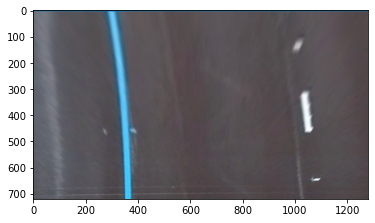

In [2]:
c = calibration.CameraCalibration()
c.load_calibration('././camera_cal/')
img = cv2.imread('test_images/test2.jpg')
undistort,mtx,dist =c.undistort_image(img)
plt.imshow(cv2.cvtColor(undistort,cv2.COLOR_BGR2RGB))
warped = image_utility.warp_image(undistort,140,470,100)
combined_binary,s_binary = thresholds.highlight_features(warped,7,(50,150),(50,200),(0.5,np.pi/2),(80,200))
plt.imshow(warped)

histogram = image_utility.calculate_histogram(combined_binary)
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
plt.plot(histogram)
midpoint = np.int(histogram.shape[0]//2)
left_base = np.argmax(histogram[:midpoint])
right_base = np.argmax(histogram[midpoint:])+midpoint

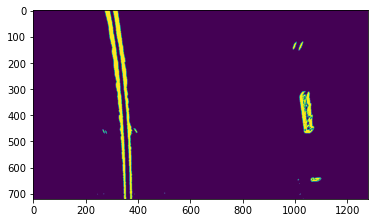

In [3]:
plt.imshow(out_img)
plt.imshow(combined_binary)

# Find Lane Pixels

In [4]:
def find_lane_pixels(binary_warped):
    number_windows = 9
    margin = 100
    min_pixels = 50
    window_height = np.int(binary_warped.shape[0]//number_windows)

    non_zero = binary_warped.nonzero()
    non_zero_y = np.array(non_zero[0])
    non_zero_x = np.array(non_zero[1])
    left_current = left_base
    right_current = right_base
    left_lane_idx = []
    right_lane_idx = []

    #%%

    for window in range(number_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = left_current - margin
        win_xleft_high = left_current + margin
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2)
        good_left_idx = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xleft_low) &  (non_zero_x < win_xleft_high)).nonzero()[0]
        good_right_idx = ((non_zero_y >= win_y_low) & (non_zero_y < win_y_high) & (non_zero_x >= win_xright_low) &  (non_zero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_idx.append(good_left_idx)
        right_lane_idx.append(good_right_idx)
        if len(good_left_idx) > min_pixels:
            left_current = np.int(np.mean(non_zero_x[good_left_idx]))
        if len(good_right_idx) > min_pixels:
            right_current = np.int(np.mean(non_zero_x[good_right_idx]))

    try:
        left_lane_idx = np.concatenate(left_lane_idx)
        right_lane_idx = np.concatenate(right_lane_idx)
    except ValueError as v:
        # Avoids an error if the above is not implemented fully
        print('error',str(v))
        pass

        # Extract left and right line pixel positions
    left_x = non_zero_x[left_lane_idx]
    left_y = non_zero_y[left_lane_idx]
    right_x = non_zero_x[right_lane_idx]
    right_y = non_zero_y[right_lane_idx]
    return left_x,left_y,right_x,right_y

In [5]:
def fit_polynomial(binary_warped):
    leftx,lefty,rightx,righty = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='blue')
    return out_img

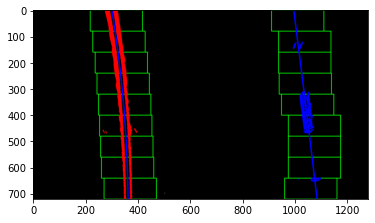

In [6]:
res= fit_polynomial(combined_binary)
plt.imshow(res)